# ClimateAI Presentation

## Goal: Predict the flow in the river for one day ahead. That is, if we want to predict the river flow for today, our prediction is based off the observations of precipitation and temperature that we have up until yesterday. 

## Load in Data

In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import warnings 
import seaborn as sns

In [3]:
def load_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

data = load_data("/Users/priya/Desktop/ClimateAI Challenge/uke_eggedal_data_challenge (1) (1) (2).pkl")

## EDA 

### Data Structure

Here we are exploring the data shape and structure to later clean it as needed. We can see that there are 5 keys in this dictionary - "flow", "flow_dates", "obs_lon_lat", "obs_dates","obs_tas", and "obs_pr". The values for each key are listed below

- flow: flow of the river cubic meters/second at a single location
- flow_dates: Date that the flow was measured
- obs_lon_lat: The location where the flow was measured (one location across all flow measurements)
- obs_dates: the date that the precipitation and temperatures were measured
- obs_tas: list of 9 temperatures in celicius from 9 surrounding locations
- obs_pr: list of 9 precipitation measurements in mm from 9 surrounding locations (negative precipitation means atmospheric evaporation > precipitation that day)

In [4]:
#pd.DataFrame(data, columns=["flow"])
# pd.DataFrame(data, columns=["flow_dates"])
pd.DataFrame(data, columns=["obs_lon_lat"])
#pd.DataFrame(data, columns=["obs_dates"])
#data.get("obs_tas")[0]
#data.get("obs_pr")[0]

,obs_lon_lat
0,9.37
1,60.23


From this initial exploration we can see 2 things of note. One is that the observation dates and the flow measurement dates are not aligned. Namely, the observation dates start and end earlier than the flow dates. So we know that we will need to do align them when we create our dataframe. And the second is that there are only 2 values given for "obs_lon_lat", which leads me to the assumption that it is actually the location of where the flow is measured. Since this value is consistent across all of the flow measurements we do not need to include it in our analysis, and it will not be considered further. 

To begin, we can make two initial dataframes one that has the "flow", "flow_dates", and one that has the "obs_dates", "obs_tas", and "obs_pr" columns. We will then need to join the "obs_dates" column on the "flow_dates" so that they match up correctly. Before we do this joining however we need to extract out our 9 temp/precip values into their own columns. Since the precipitation and temperature values for each date are actually arrays of 9 observations from nearby locations we can factor these arrays out into 9 separate columns in our dataframe. Note that this is under the assumption that each array is recorded in the same order (location 1, location 2,..., location 9).

After we do this we can then join this obs_df to the flow_df on the date.

We will save normalizing the data until after the exploratory plotting and analysis.

In [5]:
flow_df = pd.DataFrame(data, columns=["flow", "flow_dates"])
obs_df = pd.DataFrame(data, columns=["obs_dates"])

#make a temporary temperature dataframe
temp_list = data.get("obs_tas")
temp_df = pd.DataFrame(temp_list, columns=['temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'temp6', 'temp7', 'temp8', 'temp9'])

#make a temporary precipitation dataframe
precip_list = data.get("obs_pr")
precip_df = pd.DataFrame(precip_list, columns=['pr1', 'pr2', 'pr3', 'pr4', 'pr5', 'pr6', 'pr7', 'pr8', 'pr9'])

#concat temp_df and precip_df with obs_df
#drop the index so we can complete the concatination -->  add it back afterwards for easy joining with the flow_df
obs_df = pd.concat([obs_df.reset_index(), temp_df, precip_df], axis=1).set_index(keys="index", drop = False)

#concat flow and obs dfs - since both are indexed by time, can just concat and they will align by date
#drop rows where there are missing values
df = pd.concat([obs_df, flow_df], axis=1).dropna()

#now that we've dropped all the null values we can drop the obs_dates and flow_dates columns
df = df.drop(columns=['obs_dates', 'flow_dates'])

df

,index,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,flow
1958-01-04,1958-01-04,-12.8,-13.000000,-13.0,-12.5,-12.500000,-12.7,-12.000000,-12.5,-12.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.723781
1958-01-05,1958-01-05,-7.8,-7.900000,-8.4,-7.0,-7.300000,-8.6,-6.500000,-7.7,-8.3,2.0,2.2,3.0,3.3,3.7,0.7,3.1,4.2,1.1,0.960882
1958-01-06,1958-01-06,-11.0,-9.900000,-6.5,-8.5,-9.000000,-7.4,-7.900000,-6.8,-5.8,12.7,11.0,16.5,12.5,11.2,12.2,14.1,14.2,10.5,0.001000
1958-01-07,1958-01-07,-13.2,-12.200000,-7.9,-10.7,-11.300000,-9.8,-10.100000,-8.5,-7.4,6.6,6.9,9.6,7.3,6.5,5.2,10.4,5.7,3.7,0.001000
1958-01-08,1958-01-08,-19.9,-19.299999,-15.4,-18.4,-18.700001,-16.9,-17.700001,-15.9,-14.9,3.4,3.6,2.7,3.5,3.8,3.3,2.9,4.0,3.5,0.316796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,2015-12-27,-12.5,-11.700000,-8.6,-11.0,-10.900000,-9.2,-9.700000,-8.4,-7.5,2.2,0.1,1.1,1.5,0.1,0.0,0.0,0.0,0.0,2.177040
2015-12-28,2015-12-28,-12.5,-11.900000,-9.1,-11.4,-11.200000,-9.8,-10.600000,-8.6,-7.5,5.5,4.9,8.3,6.1,3.7,5.0,5.4,0.0,5.1,4.876250
2015-12-29,2015-12-29,-11.9,-11.400000,-8.4,-10.8,-10.800000,-8.6,-9.300000,-7.2,-6.3,1.8,1.7,2.1,2.7,0.2,0.8,2.2,0.0,0.0,4.998840
2015-12-30,2015-12-30,-7.0,-6.500000,-3.4,-5.9,-6.100000,-4.8,-5.000000,-3.8,-3.0,4.1,3.5,4.6,5.1,3.5,3.4,3.2,0.0,3.6,4.428777


Since we need to predict tomorrows river flow based on the data we have up to today, we need to shift the flow values by 1 step. We need to predict the flow on 10/10/2013 from the data from 10/09/2013. As a result we want each date to a corresponding "flow_tmw" or the river flow tomorrow -- this will be our outcome variable of interest.

In [6]:
#shift flow values back one and drop null values (we will lose the 12/31/2015 datapoint)
df['flow_tmw'] = df['flow'].shift(-1)
df = df.dropna()
df.head()

,index,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,...,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,flow,flow_tmw
1958-01-04,1958-01-04,-12.8,-13.000000,-13.0,-12.5,-12.500000,-12.7,-12.000000,-12.5,-12.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.723781,0.960882
1958-01-05,1958-01-05,-7.8,-7.900000,-8.4,-7.0,-7.300000,-8.6,-6.500000,-7.7,-8.3,...,2.2,3.0,3.3,3.7,0.7,3.1,4.2,1.1,0.960882,0.001000
1958-01-06,1958-01-06,-11.0,-9.900000,-6.5,-8.5,-9.000000,-7.4,-7.900000,-6.8,-5.8,...,11.0,16.5,12.5,11.2,12.2,14.1,14.2,10.5,0.001000,0.001000
1958-01-07,1958-01-07,-13.2,-12.200000,-7.9,-10.7,-11.300000,-9.8,-10.100000,-8.5,-7.4,...,6.9,9.6,7.3,6.5,5.2,10.4,5.7,3.7,0.001000,0.316796
1958-01-08,1958-01-08,-19.9,-19.299999,-15.4,-18.4,-18.700001,-16.9,-17.700001,-15.9,-14.9,...,3.6,2.7,3.5,3.8,3.3,2.9,4.0,3.5,0.316796,1.095725


We can see that there are 9 observations of precipitation and temperatures for each observation date. It would be easiest to deal with this data by simply averaging them together (the average precipitation/temperature around the river spot of interest). But doing so may cause some information loss. It might be that certain locations have a greater influence on the river flow than other locations (ex. if they are close or farther away or if they are upstream of the river so water flows down vs not). 

To check this we can look to see what the ranges of these 9 locations are (how variable are the temperature and precipitation mesasurements). 

In [7]:
#was getting settingwithCopy error -- to be safe, create a copy of the df
#bool(df.copy) 
df = df.copy()
df['range_temp'] = df.iloc[:, [1,2,3,4,5,6,7,8,9]].max(axis=1) - df.iloc[:, [1,2,3,4,5,6,7,8,9]].min(axis=1)
df['range_pr'] = df.iloc[:, [10,11,12,13,14,15,16,17,18]].max(axis=1) - df.iloc[:, [1,2,3,4,5,6,7,8,9]].min(axis=1)
df['avg_temp'] = df.iloc[:, [1,2,3,4,5,6,7,8,9]].mean(axis=1)
df['avg_precip'] = df.iloc[:, [10,11,12,13,14,15,16,17,18]].mean(axis=1)

df[['range_temp', 'range_pr']].describe()

,range_temp,range_pr
count,21177.000000,21177.000000
mean,4.041895,3.492676
std,1.432793,9.710686
min,0.200000,-20.299999
25%,3.100000,-3.600000
50%,4.100000,3.000000
75%,5.000000,10.000000
max,13.800000,74.699997


We can see that the temperature and precipitation values are not ranging too widely. In terms of temperature on average the range of the temperatures across the 9 locations is 4 degrees celcius and that for precipitation is is 3.5 mm. The median values are also very similar to the means. To further check whether it is of particular importance to keep the values factored we can look at a correlation heatmap between the variables.

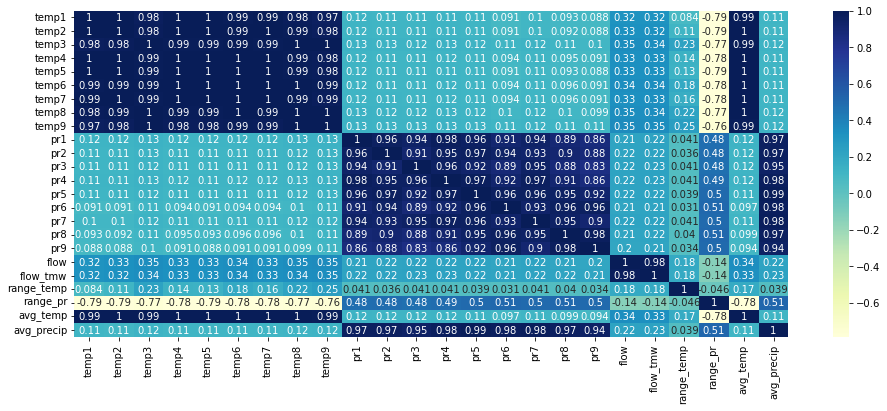

In [8]:
plt.rcParams['figure.figsize'] = [16, 6]

dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

When we look at this correlation map we can see a few point of interest. For one we can  see that the temperature values are slightly more correlated with the "flow_tmw" variable than the preceipitation values. And secondly, all of the temperature values are roughly similarly correlated with "flow" and "flow_tmw" and "avg_temp" also has a very similar correlation value. This also holds true for the 9 precipitation values -- they all share roughly the same correlation value and the "avg_precip" variable has a very similar correlation value. To me this serves as further evidence that we do not need to keep all 9 values separate, and instead can use the aggregrate terms "avg_temp" and "avg_precip" for our analysis. 

In [9]:
#drop individual temp and precipitation variables keeping just the average.
df = df.drop(columns=['temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'temp6', 'temp7', 'temp8', 'temp9',
                      'pr1', 'pr2', 'pr3', 'pr4', 'pr5', 'pr6', 'pr7', 'pr8', 'pr9', 'range_temp', 'range_pr'])
df.head()

,index,flow,flow_tmw,avg_temp,avg_precip
1958-01-04,1958-01-04,1.723781,0.960882,-12.655556,0.000000
1958-01-05,1958-01-05,0.960882,0.001000,-7.722222,2.588889
1958-01-06,1958-01-06,0.001000,0.001000,-8.088889,12.766667
1958-01-07,1958-01-07,0.001000,0.316796,-10.122222,6.877778
1958-01-08,1958-01-08,0.316796,1.095725,-17.455555,3.411111


### Exploratory Plots of Data

The first plot we might want to look at, since this is a time series dataset, is the plot of the flow over time.

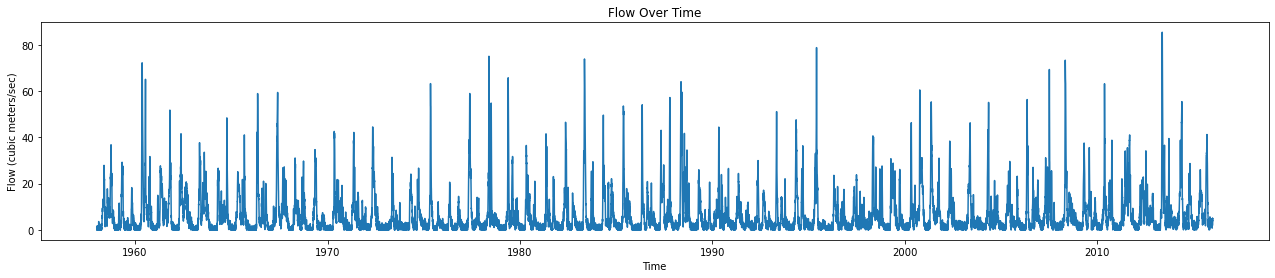

In [10]:
#plot time series data
plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(df['index'], df['flow_tmw'])
plt.xlabel('Time')
plt.ylabel('Flow (cubic meters/sec)')
plt.title('Flow Over Time')
plt.show()


We can see that while there isn't a visible trend over time, there does appear to be some roughly yearly seasonality to our data. We can check this further by looking at a trend+seasonality decomposition of our data. 

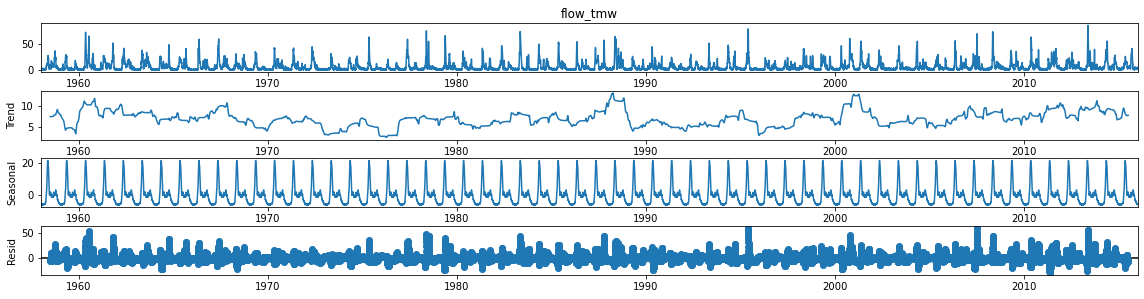

In [11]:
#plot decomposition graphs
plt.rcParams['figure.figsize'] = [16, 6]
#Period = 365 because we have daily data and might anticipate that there would be yearly trends in the data that are of interest to us
seas_d=sm.tsa.seasonal_decompose(df['flow_tmw'],model='add',period=365)
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

We can see more clearly in the above plots how, there appears to be little trend but a definite seasonality to our data. Based off of this we know that I would begin to think that we might be working with SARIMAX model (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables model). 

In addition to looking at the time series plots of our data there are a couple of different exploratory precipitation and temperature plots we might want to look at:
- Precipitation and temperature over time
- Precipitation and temperature vs Flow
- The distribution of precipitation/temperature values

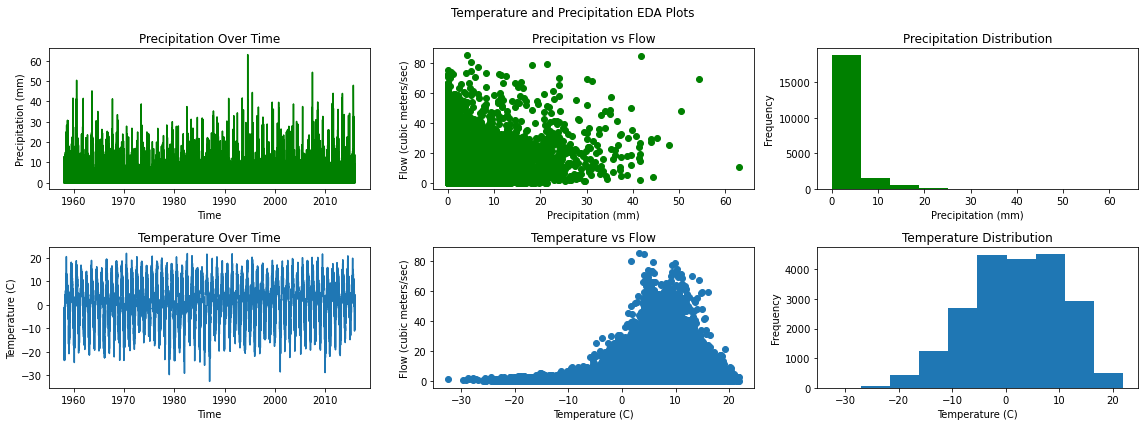

In [12]:
#EDA plots
fig, axs = plt.subplots(2,3)
fig.suptitle('Temperature and Precipitation EDA Plots')

axs[0,0].plot(df['index'], df['avg_precip'], color = "green")
axs[0,0].set(xlabel='Time', ylabel = 'Precipitation (mm)')
axs[0,0].set_title('Precipitation Over Time')

axs[1,0].plot(df['index'], df['avg_temp'])
axs[1,0].set(xlabel='Time', ylabel = 'Temperature (C)')
axs[1,0].set_title('Temperature Over Time')

axs[0,1].scatter(x=df['avg_precip'], y=df['flow_tmw'], color = "green")
axs[0,1].set(xlabel='Precipitation (mm)',ylabel='Flow (cubic meters/sec)')
axs[0,1].set_title('Precipitation vs Flow')

axs[1,1].scatter(x=df['avg_temp'], y=df['flow_tmw'])
axs[1,1].set(xlabel='Temperature (C)', ylabel='Flow (cubic meters/sec)')
axs[1,1].set_title('Temperature vs Flow')

axs[0,2].hist(df['avg_precip'], color = "green")
axs[0,2].set(xlabel='Precipitation (mm)',ylabel='Frequency')
axs[0,2].set_title('Precipitation Distribution')

axs[1,2].hist(df['avg_temp'])
axs[1,2].set(xlabel='Temperature (C)', ylabel='Frequency')
axs[1,2].set_title('Temperature Distribution')

fig.tight_layout()

Most notable in these plots is the fact that we can see that a) the precipitation distribution is extremely right skewed, meaning that for a large portion of our dataset the average precipitation is 0 and b) there does not appear to be a strong relationship between the avg_precipitation and the flow.

To address this right skew in the average precipitation values I considered applying a log transformation, but when I checked the data over 1/3 of the avg_precipitation values were 0. I attempted to address this in the plot below where I added a 1 to these 0 values so that their log would return essentially 0. We can see that after applying this transformation our data is much more normally distributed.

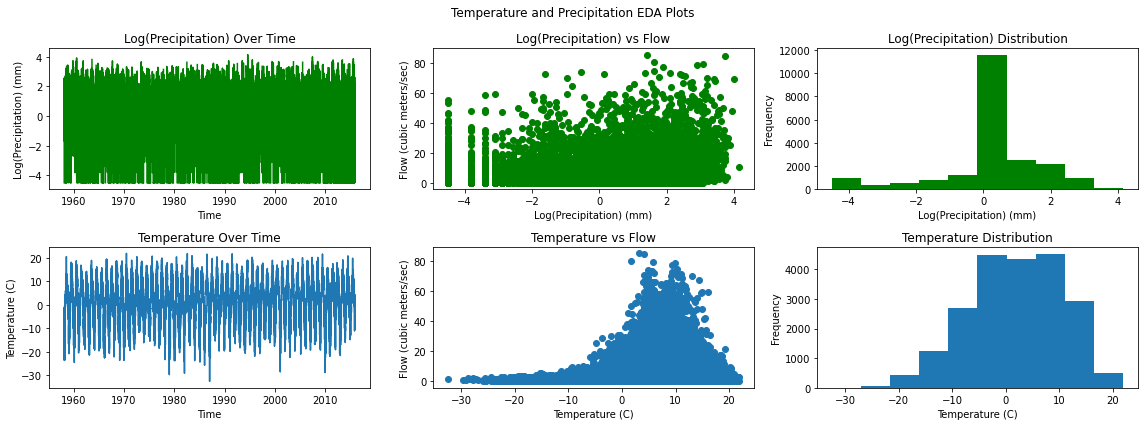

In [13]:
warnings.filterwarnings("ignore") 

fig, axs = plt.subplots(2,3)
fig.suptitle('Temperature and Precipitation EDA Plots')

axs[0,0].plot(df['index'], np.log(np.where(df['avg_precip']==0,1^-100,df['avg_precip'])), color = "green")
axs[0,0].set(xlabel='Time', ylabel = 'Log(Precipitation) (mm)')
axs[0,0].set_title('Log(Precipitation) Over Time')

axs[1,0].plot(df['index'], df['avg_temp'])
axs[1,0].set(xlabel='Time', ylabel = 'Temperature (C)')
axs[1,0].set_title('Temperature Over Time')

axs[0,1].scatter(x=np.log(np.where(df['avg_precip']==0,1^-100,df['avg_precip'])), y=df['flow_tmw'], color = "green")
axs[0,1].set(xlabel='Log(Precipitation) (mm)',ylabel='Flow (cubic meters/sec)')
axs[0,1].set_title('Log(Precipitation) vs Flow')

axs[1,1].scatter(x=df['avg_temp'], y=df['flow_tmw'])
axs[1,1].set(xlabel='Temperature (C)', ylabel='Flow (cubic meters/sec)')
axs[1,1].set_title('Temperature vs Flow')

axs[0,2].hist(np.log(np.where(df['avg_precip']==0,1,df['avg_precip'])), color = "green")
axs[0,2].set(xlabel='Log(Precipitation) (mm)',ylabel='Frequency')
axs[0,2].set_title('Log(Precipitation) Distribution')

axs[1,2].hist(df['avg_temp'])
axs[1,2].set(xlabel='Temperature (C)', ylabel='Frequency')
axs[1,2].set_title('Temperature Distribution')

fig.tight_layout()

We can see from the graphs above that the precipitation data now looks more normal. But, when we look at the graph of Log(precipitation) vs Flow we see that the two variables are still relatively uncorrelated and they do not appear to have a strong relationship. By contrast the temperature vs flow graph does show some seemingly quadratic relationship between temperature and flow, but it is not clearly defined and appears to be variable.

# Model Making

### Intuition

We are building a forecasting model based off of time and feature data. My initial thoughts were to use a SARIMAX model to model the data and to be able to forecast the river flow. But another option could be working with a linear regression model that uses time as one of it's features. The linear regression model would have the benefit of being highly interpretable by comparison to the SARIMAX model. As a result I decided to try modelling both and comparing my results.

## Linear Regression

We can begin with constructing the simpler linera regression model. In this case I have decided to use the avg temperature, avg precipitation, month, and year as my input features. I'm hoping that by including the month and the year I can capture some of the seasonality that I saw in the decomposition plot above. Note that in log transforming the precipitation values to 

In [14]:
warnings.filterwarnings("ignore") 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_df = df.copy()

#add month and year variables to df
lin_df['month'] = pd.DatetimeIndex(lin_df['index']).month
lin_df['year'] = pd.DatetimeIndex(lin_df['index']).year

# define input variables (x) and ouput variable (y)
#apply log transformation to pr
lin_df['avg_precip'] = np.log(np.where(df['avg_precip']==0,1,df['avg_precip']))

#create quadratic term to reflect plot in EDA
#lin_df['quad_temp'] = df['avg_temp']**2
#tested this variable and it had little effect on the rmse

x = lin_df[['avg_temp', 'avg_precip']]
y = lin_df[['flow_tmw']]

# Split the data into 80:20 train and test sets using sklearn
lX_train, lX_test, ly_train, ly_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Instantiate a linear regression model
lin_model = LinearRegression()

# Fit the model to the training data
lin_model.fit(lX_train, ly_train)

coefs = pd.DataFrame(zip(lX_train.columns, lin_model.coef_[0]))
coefs

,0,1
0,avg_temp,0.364620
1,avg_precip,0.767339


In [15]:
# Make predictions using the train/test data
lin_preds = lin_model.predict(lX_test)
lin_preds_train = lin_model.predict(lX_train)

#compare predictions to actual values with rmse
train_rmse = np.sqrt(mean_squared_error(ly_train, lin_preds_train))
print("Train RMSE is:",train_rmse)
test_rmse = np.sqrt(mean_squared_error(ly_test, lin_preds))
print("Test RMSE is:",test_rmse)



Train RMSE is: 9.130843247702375
Test RMSE is: 8.662189117041097


We can see that our model has a test RMSE of 8.66, which tells us that our model is on average off in it's estimation of the flow by 8.4156 cubic meters/second.

## SARIMAX Modelling

In the second model I wanted to look at the data as a time series dataset

To begin, we need to normalize our data. The scale difference between the flow, temperature, and the precipiation values is large, but when we normalize the data we can scale all of the variables to be in the range [0,1].

In [16]:
from sklearn.preprocessing import MinMaxScaler

# need separate scaler instances for each variable group - temp, precip, flow
scaler_temp = MinMaxScaler()
scaler_precip = MinMaxScaler()
scaler_flow = MinMaxScaler()

# scale each group

df[['avg_temp']] = scaler_temp.fit_transform(df[['avg_temp']])
df[['avg_precip']] = scaler_precip.fit_transform(df[['avg_precip']])
df[['flow_tmw']] = scaler_flow.fit_transform(df[['flow_tmw']])


df.head(3)

,index,flow,flow_tmw,avg_temp,avg_precip
1958-01-04,1958-01-04,1.723781,0.011251,0.365141,0.000000
1958-01-05,1958-01-05,0.960882,0.000011,0.455864,0.041093
1958-01-06,1958-01-06,0.001000,0.000011,0.449121,0.202646


Now that we have scaled our data we need to create our training and testing set. Since we are working with time series data our test set much be "younger" than our training data. That is, our test set needs to times that come after our training data. Here we will use a typical 80:20 (train:test) split for our data. 

In addition, we need to split the data further in the X_train, Y_train, X_test, and Y_test sets. 

In [17]:
train_size=int(len(df) *0.8)
test_size = int(len(df)) - train_size
x = df[['avg_temp', 'avg_precip']]
y = df[['flow_tmw']]

x_train, y_train = x[:train_size].dropna(), y[:train_size].dropna()
x_test, y_test = x[train_size:].dropna(), y[train_size:].dropna()

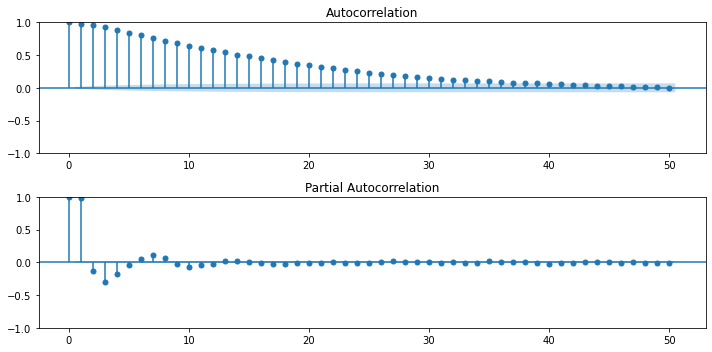

In [18]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_train, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_train, lags=50, ax=ax[1])
fig.tight_layout()
plt.show()

We can see some trend and seasonality in our PACF and ACF plots (oscillations in the PACF and decay in the ACF), and as a result we should check whether our data is stationary over time. If not then we would consider differencing our data once to see if we can get a stationary time series. To test whether the data is stationary (constant mean/variance) we can conduct the augmented dickey-fuller test. If the data is stationary we can proceed with modeling, if it is not we need to conduct some sort of differencing to make the data stationary. 

In [19]:
from pmdarima.arima.stationarity import ADFTest

#get the p-value for the test and whether we should difference the data
adf_test = ADFTest(alpha=0.05)
p, should_diff = adf_test.should_diff(y_train)

#if data is stationary then p<0.05 and should_diff will be False
p, should_diff

(0.01, False)

The ADF test shows us that our data is stationary and that we do not need to difference our data. Interestingly this also points to our data lacking seasonality. I'm not currently sure why this might be, given that when we decompose our data we can see a seasonal pattern. But for the sake of this analysis I will move forward assuming no seasonality and assuming stationary data. As a final sanity check I am conducting a CH Test for seasonality. I'm less familiar with this test but know in a general sense that it tests the stablility of the seasonality of data. In this case the estimate_seasonal_differencing_term() function provides a parameter estimate for the Seasonal Differencing term in an ARIMA model. If this term is 0 that means that it estimates that no differencing term is need. Otherwise it estimates the degree of seasonal differencing needed to removal seasonality from the data.

In [20]:
from pmdarima.arima import CHTest

CHTest(365.25).estimate_seasonal_differencing_term(x=y_train)

0

The CH Test estimator estimated the seasonal differencing term to be 0, this is in line with the results of the ADF test and so I will move forward assuming that the data is stationary.

Knowing this, we can use the ARIMAX model and the auto_arima function to optimize the p,d,q values and return to us a model that minimizes the criteria we choose. The auto_arima function takes in a series of parameters and stepwise compares different (S)ARIMA models by a chosen criterion. Since we have determine there is no seasonality in the data, I have ommitted the seasonal parameters from the function call.

Here we are using the AIC to select our model. This metric is considers the number of parameters and the maximum likelihood estimator and determines, from a set of models, which model gives the best predictions. The lower the AIC the better the model is at generating preddiction, and typically the AIC penalizes models with a larger number of parameters.

In [21]:
model=auto_arima(y_train, exogenous= x_train,
                 start_p=1, start_q=1, max_p=7, max_q=7, d=1, max_d=7, 
                 error_action='ignore', suppress_warnings=True, stepwise=True)
model

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

From the auto_arima function we have found the ARIMA(3,1,0) model to be the best model for our data. Now that we know this we can train such a model on our data and evaluate it's performance. 

In [24]:
warnings.filterwarnings("ignore") 

from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(y_train, exog=x_train, order=(3,1,0), enforce_invertibility=False, enforce_stationarity=False)
fitted_model = model.fit(full_output = False);

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.50528D+00    |proj g|=  1.05698D-01

At iterate    5    f= -2.50567D+00    |proj g|=  2.42980D-02

At iterate   10    f= -2.50573D+00    |proj g|=  3.51735D-02

At iterate   15    f= -2.50573D+00    |proj g|=  6.29177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     34      1     0     0   8.263D-03  -2.506D+00
  F =  -2.5057286145809319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Now that we have our SARIMAX model we can test it's prediction capabilities on our test dataset, and get the RMSE of our train and test predictions.

In [23]:
#forecast the y_test values
forecast = fitted_model.get_forecast(steps=test_size, exog=x_test)
fcast_pred_mean = forecast.predicted_mean

#all of these values are still normalized and we need to revert them to be able to compare the RMSE with the linear model
unscale_fcast_pred_mean = scaler_flow.inverse_transform(fcast_pred_mean.values.reshape(-1, 1))
unscale_y_test = scaler_flow.inverse_transform(y_test.values.reshape(-1, 1))

sarimax_test_rmse = np.sqrt(mean_squared_error(unscale_y_test, unscale_fcast_pred_mean))
print("Test RMSE is:",sarimax_test_rmse)


Test RMSE is: 11.47373968107085


 We can see that our test RMSE for the SARIMAX model is 11.4737 which is higher than the RMSE we got for the linear model, and on this metric and the fact that the linear model is more easily interpretable is why I would choose to go with the linear model. 
 
 To help visualize the results that I got from the SARIMAX model we can also plot the predicted values against the true flow values and also add in the 95% confidence intervals. Note that this is a graph of the scaled values. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


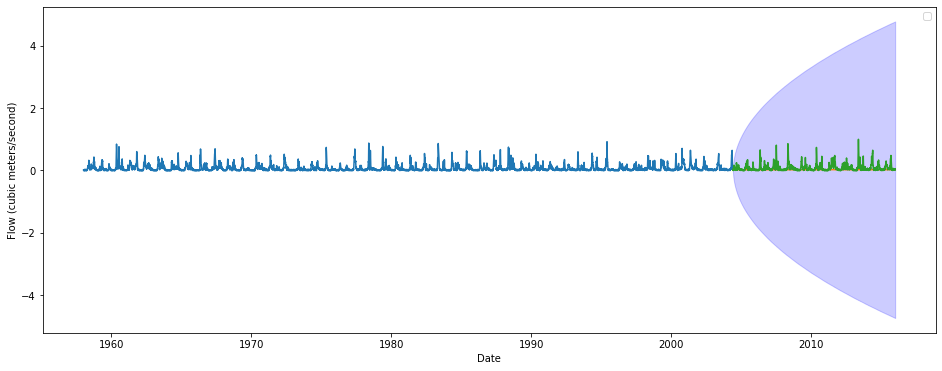

In [25]:
#get confidence interval for forecasts
forecast_confint = forecast.conf_int(alpha= 0.05)

#reset index to date-time
fcast_pred_mean_df=fcast_pred_mean.to_frame().set_index(x_test.index)
forecast_confint=forecast_confint.set_index(x_test.index)
 
#plot training data
plt.plot(y_train['flow_tmw'])
#plot predicted values for test set (green)
plt.plot(fcast_pred_mean_df['predicted_mean'])
#plot true values for test set (blue)
plt.plot(y_test['flow_tmw'])
#plot confidence intervals for test set predictions
plt.fill_between(x= forecast_confint.index,
                y1=forecast_confint.iloc[:, 0], y2=forecast_confint.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Flow (cubic meters/second)')
plt.legend()
plt.show();

We can see that the confidence intervals on the graph below are extremeley wide on our predicted values and there is a lot of uncretainity in the predictions. I would guess that this may have to do with the seasonality that I was unable to resolve earlier. 